In [ ]:
!pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt                 # This will import plotting module
import numpy as np
!pip install opencv-python
import cv2
from typing import Optional 

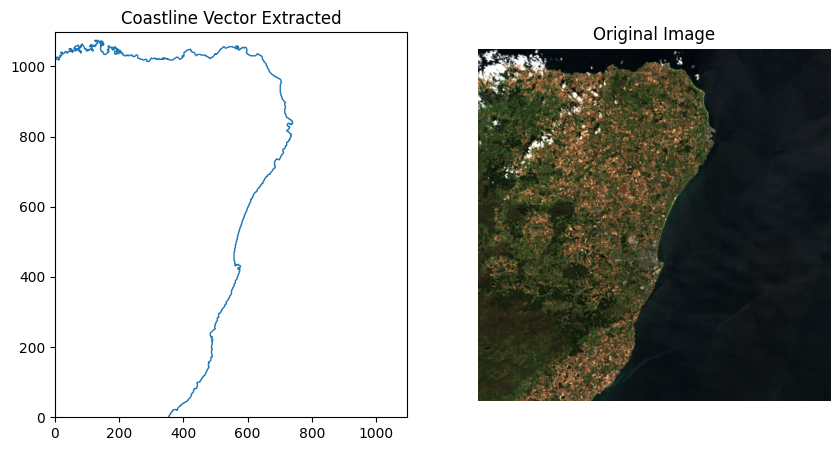

In [19]:
class MarchingSquares:
    def __init__(self,file: str,downsample_factor: float)->None:
        self.downsample_factor = downsample_factor
        self._reset_state

    def _reset_state(self)->None:
        self.image: Optional(list[[float,float,float]])= None
        self.result_image: Optional(list[float])= None
        self.threshold: Optional(float)= None
        self.state_dict:Optional(dict[tuple[int,int],bool]) = None
        self.x_len:Optional(int) = None
        self.y_len:Optional(int) = None
        self.vectors:Optional(list[tuple[int,int]]) = None
        self.shapes:Optional(list[list[tuple[int,int]]]) = None
        self.coastline_vector:Optional(list[tuple[int,int]]) = None

    '''Reads a tif file with bgr formatting, resizes the image if necessary and then converts
    into a hsv file using the cv2 library. '''
    def _readfile(self)->None:
        image_bgr: list[[float,float,float]] = cv2.imread(self.file)
    
        #If necessary for performance speed, compress the file
        new_size: tuple[int,int] = (int(image_bgr.shape[0]*self.downsample_factor),int(image_bgr.shape[1]*self.downsample_factor))
        image_resized: list[[float,float,float]]= cv2.resize(image_bgr,new_size,interpolation =cv2.INTER_AREA)

        #For the chosen segmentation method it has been decided to segment the image
        #using the hue channel of a converted hsv image to distinguish between land and sea.

        self.image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

        
    '''Uses the Otsu segmentation method to distinguish between land and sea to extract the coastline vector. 
    This will be later replaced by the UNET section of the pipeline. The Otsu threshold works by creating a histogram of the hue values in the hsv image.
    This will result in two large broad peaks in the histogram corresponding to the hue values of land more oranges and greens, whereas the sea will be distinctly blue.
    The threshold value is then the point between these two peaks. The output of this function is a binary valued segmented image 0 for sea and 1 for land'''
    def _otsu_segmentation(self)->None:
        hue_channel: list[float] = self.image[: , : , 0]
        
        self.threshold , self.result_image = cv2.threshold(hue_channel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
        
    '''Creating a function that will weight the dictionary points such that they can be sorted from left to right starting at the bottom left.'''
    def _sort_key(self, point: tuple[int,int])->int:
        return point[1]*100 +point[0]
    
    '''This extracts the points from the image and stores them in a dictionary with each point either corresponding to black or white. 
     The coordinates are doubled and incresed by one as vector lines will be drawn halfway between these points. 
     This can be changed to match the original resolution of the image, however vectors will then be made of floating point coordinates.  '''
    def _point_array(self)->None:
        black: list[int,int] = []
        white: list[int,int] = []

        x: list[int] = self.result_image.shape[0]-1
        y: list[int] = self.result_image.shape[1]-1

        for i in range(x+1):
            for j in range(y+1):
                if self.result_image[i][j]==1:
                    black.append([j,x-i])
                else:
                    white.append([j,x-i])

        black = np.array(black)*2 + 1
        white = np.array(white)*2 + 1

        xblack:list[int] = [point[0] for point in black]
        yblack:list[int] = [point[1] for point in black]

        xwhite:list[int] = [point[0] for point in white]
        ywhite:list[int] = [point[1] for point in white]

        state:dict[tuple[int,int],bool] = {tuple(point): True for point in black}
        state.update({tuple(point): False for point in white})
        sorted_dict:list[tuple[tuple[int,int],bool]] = sorted(state.items(), key=lambda x: self._sort_key(x[0]))
        self.state_dict = dict(sorted_dict)

        self.x_len = max(xblack+xwhite)
        self.y_len = max(yblack+ywhite)

    '''Splitting the point array space into squares 1 pixel wide. These squares have corners lying on either a black or white point. 
    The square as a whole adopts a value through the marching squares method, for a square centred at (2,2) it is corners at A(1,1),B(3,1),C(1,3) and D(3,3). 
    Associating each of these corners with a binary weighting value A:2^0, B:2^2, C:2^3, D:2^4 and then summing these values multiplied by either 0 or 1
    dependeing on the state of the point they sit on 1 for white and 0 for black will produce a value from 0 to 15. Each of these values coresponds to a line shape 
    which will be used to create a coastline vector.'''   
    def _get_value(self, i:int,j:int)->int:
        A = int(self.state_dict[(i    , j    )])
        B = int(self.state_dict[(i + 2, j    )])
        C = int(self.state_dict[(i    , j + 2)])
        D = int(self.state_dict[(i + 2, j + 2)])
        return A + B*2 + C*4 + D*8
    
    '''Generates the line associated with the index of the square. This is done by outputting a start and end point for a line. 
    Indexes of 6 and 9 are special in that two lines are created.'''
    def _generate_edges(self,i:int,j:int,index:int)->list[tuple[tuple[int,int]]]:
        x: int
        y:int
        x,y = i,j 
        vector:list[tuple[tuple[int,int],tuple[int,int]]] = []
        start:tuple[int,int]
        end:tuple[int,int]

        if index == 0 or index == 15:
            return 
        elif index == 1 or index == 14:
            start = (x+1,y)
            end = (x,y+1)
            vector.append((start,end))
        elif index == 2 or index == 13:
            start = (x+1,y)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 3 or index == 12:
            start = (x,y+1)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 7 or index == 8:
            start = (x+2,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 9:
            start = (x,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
            start = (x+1,y)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 5 or index == 10:
            start = (x+1,y)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 4 or index == 11:
            start = (x,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 6:
            start = (x+2,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
            start = (x+1,y)
            end = (x,y+1)
            vector.append((start,end))
        
        return vector

    def _list_vectors(self)->None:

        vectors:list[tuple[int,int],tuple[int,int]] = []
        i:int
        j:int
        for j in range(1,self.y_len,2):

            for i in range(1,self.x_len,2):

                index:int = self._get_value(i,j)
                
                if index == 6 or index == 9:

                    double_vec:list[tuple[tuple[int,int],tuple[int,int]]] = self._generate_edges(i,j,index)
                    vectors.append([double_vec[0]])
                    vectors.append([double_vec[1]])

                else:

                    vectors.append(self._generate_edges(i,j,index))

        self.vectors = [x for x in vectors if x is not None] #filtering None values
        
    '''The purpose of this funciton is to connect all adjacent vector lines to create one long "coastline vector". 
    This is done by creating a set of the vector lines from the previous function. The first in this set is popped out and the start and end points 
    are added to a shape vector. The set vectors_to_remove is then looped through until the start or end point of one of these vectors "matches" the start or end point of the popped vector.
    The matched vector is then added to the shape vector, for example if the start point of the popped vector matched the end point of the matched vector then the start coordinate of the matched vector
    will be added to the shape array. This is then repeated with the new start and end vector of the shape until there is no match. 
    In this circumstance, the shape is appended to a "shapes" array and a new shape is created and the process repeats until there are no vectors left to remove. At the end of this function, the shapes are ordered dependeing on their size. 
    The main coastline vector will be the longest whereas there will be shorter vectors corresponding to islands.
    '''
    def _vector_shapes(self)->None:
        shapes:list[list[tuple[int,int]]] = []
        vectors_to_remove:set[int] = set(range(len(self.vectors)))
        while vectors_to_remove:
            shape:list[tuple[int,int]] = []
            
            # Get the first vector and extract the tuple of points
            vector:list[tuple[int,int]] = self.vectors[vectors_to_remove.pop()][0] 

            start_point:tuple[int,int]
            end_point:tuple[int,int]

            start_point, end_point = vector 

            # Add the start and end points to the shape
            shape.extend([start_point, end_point])
            matched:bool = True
            
            while matched:

                matched = False

                idx:int

                for idx in list(vectors_to_remove):
                    
                    vec:list[tuple[int,int]] = self.vectors[idx][0] 

                    # Check if the vector connects to the shape
                    if vec[0] == end_point:
                        # append to end point
                        end_point = vec[1]
                        shape.append(end_point)
                        vectors_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[1] == end_point:
                        # append to start point
                        end_point = vec[0]
                        shape.append(end_point)
                        vectors_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[0] == start_point:
                        
                        start_point = vec[1]
                        shape.insert(0, start_point)  # Add to the beginning of the shape
                        vectors_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[1] == start_point:
                        # If the start of the shape matches a reversed vector prepend it
                        start_point = vec[0]
                        shape.insert(0, start_point)
                        vectors_to_remove.remove(idx)
                        matched = True
                        break

         
            shapes.append(shape)
        
        self.shapes = sorted(shapes, key = lambda shape: len(shape), reverse = True)
        
    '''This is the plotting function that will plot the main coastline vector. The range of the for loop can be changed to plot any islands as well.'''
    def _show_coastline(self)->None:

        plt.figure(figsize = (10,5))
        plt.subplot(1,2,1)
        plt.title("Coastline Vector Extracted")
        for i in range(1):
            coastline_vector:list[tuple[int,int]] = self.shapes[i]
            xcoords:list[tuple[int,int]] = []
            ycoords:list[tuple[int,int]] = []
            for point in coastline_vector:
                xcoords.append(point[0])
                ycoords.append(point[1])
            plt.plot(xcoords,ycoords,linewidth = 1)    
        plt.xlim((0,self.x_len))
        plt.ylim((0,self.y_len))
        

        plt.subplot(1,2,2)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_HSV2RGB))
        plt.axis('off')
    
        plt.show()
        self.coastline_vector = self.shapes[0]
        
    
    def run(self,file)->None:
        self.file = file
        
        self._readfile()
        self._otsu_segmentation()
        self._point_array()
        self._list_vectors()
        self._vector_shapes()
        self._show_coastline()

file:str = "Aberdeenshire.tif"
downsample_factor:float = 0.05
Aberdeenshire: MarchingSquares= MarchingSquares(file,downsample_factor)
Aberdeenshire.run(file)